# Introduction

In this notebook I try to make prediction on the Gold price using **deep learning** methods. The workflow of this prediction and its steps are as the following:
## Data Preparation

After importing the data which is the Gold price from August of 2000 to October of 2022, we need to prepare the dataset by feature engineering and exploratory data analysis. Briefly, we add lag columns and their statistics, and also an important bags of features; **Indicators**.

Indicators are very useful in the field of finance and most of technical analysts use them for their analysis.
To get most of this type of features, I use a very nice library named Talib which have lots of famous and prevalent indicators and also Pattern Recognition functions. I tried to use them all and let my mutual information function decide the best of them considering my target which is "Close" price of each day.\
For more information you can follow the link below:\
[Python wrapper for TA-Lib](https://mrjbq7.github.io/ta-lib/)

After creating the features, a function is defined that prepare the dataset. 

## Deep Learning Model

I wrote a Multi layer perceptron (MLP) neural network that is tuned with the **Optuna** and the best architecture applied for forcasting the Close price.
I remove the hyperparameters tuning step due to its time consuming and did it on my own system.
Also I wrote another MLP model which is not tuned for a specific column and can be used for any target. (I hope so!)

In [1]:
conda install -c conda-forge ta-lib

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - ta-lib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    libta-lib-0.4.0            |       h166bdaf_1         517 KB  conda-forge
    openssl-1.1.1s             |       h0b41bf4_1         1.9 MB  conda-forge
    ta-lib-0.4.19              |   py37hda87dfa_4         377 KB  conda-forge
   

In [2]:
import math
import random 
import statistics
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import set_option
from numpy import mean
from numpy import std
from numpy import arange
from pandas import read_csv
from sklearn.feature_selection import VarianceThreshold
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers.core import Dense, Activation, Dropout
import tensorflow as tf
from keras.callbacks import Callback
from keras import backend
from keras.layers import Dense, BatchNormalization, Dropout
from  tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from math import floor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from numpy import sqrt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import PowerTransformer
from numpy.random import seed
import talib
from talib.abstract import *
import warnings
warnings.filterwarnings('ignore')

In [3]:
Gold = pd.read_csv(r'/kaggle/input/gold-price-2000-2022/gold price - 2000 edited.csv',header=0, index_col=0, parse_dates=True,squeeze=True)
Gold = Gold[Gold.Open !=0]
Gold = Gold[Gold.High !=0]
Gold = Gold[Gold.Low !=0]
Gold = Gold[Gold.Close !=0]
Gold

,Open,High,Low,Close,Volume
Date,,,,,
2000-08-31,274.8,278.3,274.8,278.3,0
2000-09-01,277.0,277.0,277.0,277.0,0
2000-09-05,275.8,275.8,275.8,275.8,2
2000-09-06,274.2,274.2,274.2,274.2,0
2000-09-07,274.0,274.0,274.0,274.0,125
...,...,...,...,...,...
2022-09-30,1661.7,1672.7,1658.0,1662.4,548
2022-10-03,1667.2,1700.0,1661.9,1692.9,410
2022-10-04,1701.2,1728.0,1696.0,1721.1,291


# Data Preparation

In [4]:
# add lags we set in "lag_list" and place them in order to the dataset.

def Add_Lag(data,col,lag_list):
    
    position = data.columns.tolist().index(col)
    
    for lag in lag_list:
    
        col_val = data[col].shift(lag)

        col_name = col+'_lag:'+'{length}'.format(length=lag)

        data.insert(loc=position, column=col_name, value=col_val)
        

    return data

In [5]:
def Indicator(Data):

    data = pd.DataFrame()
    data['Open'] = Data['Open']
    data['High'] = Data['High']
    data['Low'] = Data['Low']
    data['Close'] = Data['Close']
    data['Volume'] = Data['Volume']


    Orginal_columns_names = ['Open', 'High', 'Low', 'Close', 'Volume']
    
    #we apply indicators on one lage data
    Open = data['Open'].shift(1)
    High = data['High'].shift(1)
    Low = data['Low'].shift(1)
    Close = data['Close'].shift(1)
    Volume = data['Volume'].shift(1)

    Orginal_columns_values = {'open':Open,'high':High,'low':Low,'close':Close,'volume':Volume}

    #Gathering all functions in the Talib library
    Talib = talib.get_function_groups()
    Groups = list(Talib.keys())
    Indicators = []
    for group in Groups:
        for g in Talib[group]:
            Indicators.append(g)
    #As the following two functions are not returning an array with length of our data.shapep[0], we remove it
    Indicators.remove('MAVP')
    Indicators.remove('OBV')

    for indicator in Indicators:
        indicator = eval(indicator)
        
        #Here we have two types of functions(indicators,...):
        #The ones need just one column and the others which need more

        if len(indicator.output_names)==1:

            if list(indicator.get_input_names().values()) == ['close']:

                for col in Orginal_columns_names:

                    lagged_col = data[col].shift(1)

                    new_col = indicator(lagged_col)

                    name = indicator.info['name']

                    col_name = col+'_'+'{Name}'.format(Name=name)

                    data[col_name] = new_col

            else: #Functions need more than one features, e.g. [High, Low, Close, Open]

                name = indicator.info['name']

                inputs = list(indicator.get_input_names().values())

                if len(inputs)==2:

                    new_col = indicator(Orginal_columns_values[inputs[0]],Orginal_columns_values[inputs[1]])

                    data[name] = new_col
                    
                elif len(inputs)==3:

                    new_col = indicator(Orginal_columns_values[inputs[0]],Orginal_columns_values[inputs[1]],Orginal_columns_values[inputs[2]])
                    
                    data[name] = new_col
                    
                elif len(inputs)==4:
                    
                    new_col = indicator(Orginal_columns_values[inputs[0]],Orginal_columns_values[inputs[1]],Orginal_columns_values[inputs[2]],Orginal_columns_values[inputs[3]])
                    
                    data[name] = new_col
    
    remove_col = []
    for col in data.columns:
        if float('-inf') in data[col].values: #Remove columns that have very large values
            remove_col.append(col)
        if data.tail(data.shape[0]-100)[col].isnull().values.any()==True: #remove columns that have nan values which are not cause of lags
            remove_col.append(col)
            
    remove_col = remove_col+Orginal_columns_names
    data.drop(remove_col,axis=1,inplace=True)

    return data

In [6]:
def add_diff(data,col): #A simple type of features which calculate just the difference between sequential values in each columns

    position = data.columns.tolist().index(col)

    diff = [0,0]

    for i in range(1,data.shape[0]-1):

        difference = data[col][i] -  data[col][i-1]

        diff.append(difference)
    
    col_name = col+'_difference'

    data.insert(loc=position, column=col_name, value=diff)

    return data

In [7]:
def Roll_Stats(data,col,Roll_Window): #Calculating simple statistics of the data
    
    lag = 1
    
    def difference(l1,l2):
        diff = []
        for i in range(len(l1)):
            diff.append(l1[i]-l2[i])
        
        return diff

  
    position = data.columns.tolist().index(col)
    
    for window in Roll_Window:
        
        Window = window
        col_val = data[col].shift(lag)
        window = col_val.rolling(window=window)
        means = window.mean()
        std = window.var()
        Max  = window.max()
        Min = window.min()
        diff = difference(Max,Min)
    
        col_name_mean = col+'_mean'+'_lag:'+'{length}'.format(length=lag)+\
        '_win:'+'{length}'.format(length=Window)
        col_name_std = col+'_std'+'_lag:'+'{length}'.format(length=lag)+\
        '_win:'+'{length}'.format(length=Window)
        col_name_max = col+'_max'+'_lag:'+'{length}'.format(length=lag)+\
        '_win:'+'{length}'.format(length=Window)
        col_name_min = col+'_min'+'_lag:'+'{length}'.format(length=lag)+\
        '_win:'+'{length}'.format(length=Window)
        col_name_diff = col+'_diff'+'_lag:'+'{length}'.format(length=lag)+\
        '_win:'+'{length}'.format(length=Window)

        data.insert(loc=position, column=col_name_mean, value=means)
        data.insert(loc=position, column=col_name_std, value=std)
        data.insert(loc=position, column=col_name_max, value=Max)
        data.insert(loc=position, column=col_name_min, value=Min)
        data.insert(loc=position, column=col_name_diff, value=diff)
        

    return data

In [8]:
# this is the final function that use above functions and return the prepared dataset
def Prepare_Data(data,col,Lag_list,Roll_window):
    
    if min(Roll_window) <2:
        print('Roll_window must be greater than 1.')

    Add_Lag(data,col,Lag_list)
    Roll_Stats(data,col,Roll_window)
    add_diff(data,col)

    return data  

In [9]:
def Prepare(Data,col,Lag_list,Roll_window):

    data = pd.DataFrame({col:Data[col]}, index = Data.index)
    
    #prepare the target column we wish to predict
    data = Prepare_Data(data,col,Lag_list,Roll_window)
    
    #these three columns with their new features add to the final dataset, whatever the target column is. 
    Open = Prepare_Data(pd.DataFrame(Data['Open']),'Open',Lag_list,Roll_window)
    Close = Prepare_Data(pd.DataFrame(Data['Close']),'Close',Lag_list,Roll_window)
    Volume = Prepare_Data(pd.DataFrame(Data['Volume']),'Volume',Lag_list,Roll_window)
    Low = Prepare_Data(pd.DataFrame(Data['Low']),'Low',Lag_list,Roll_window)
    High = Prepare_Data(pd.DataFrame(Data['High']),'High',Lag_list,Roll_window)
        
    #now we merge all the dataset we created above together to have a complete dataset 
    data = pd.concat([Open,Close,Volume,High,Low],axis=1)
    
    if col == 'High':
        data=data.drop(['Low','Open','Close','Volume'],axis=1)
    
    elif col == 'Low':
        data=data.drop(['High','Open','Close','Volume'],axis=1)
    
    elif col == 'Open':
        data=data.drop(['High','Low','Close','Volume'],axis=1)
    
    elif col == 'Volume':
        data=data.drop(['High','Open','Close','Low'],axis=1)
        
    """
    ***Important***
    
    As we aim to make forcasting the close price, we have [Open, Low, High, Value] values for that day.
    
    But with this function we can make prediction on any other features.
    """
    
    target = data[col]
    data.drop([col],axis=1,inplace=True)

    data.insert(loc=data.shape[1], column=col, value=target)
    return data

In [10]:
def mutual_information_lag(Data,target_col,k_best):
    
    mic_ordered = {}
    seed(21)
    
    #calculating the mutual information score between lag columns and target column; one of {Open,Close,High,Low,Volume} which selected above
    for col in Data.columns[1:-1]:
        col_val = Data[col].values
        #Due to existing some large values in some columns which are hard to handle for calculating their mutual information with the target
        #we set a bound for maximum value in columns
        if max(col_val) < 1000000: 
            score = mutual_info_regression(col_val.reshape(-1, 1), Data[target_col].values)
            mic_ordered[col] = score[0]
    
    #descend sort the lag list by their mutual information score
    sorted_mic = {k: v for k, v in sorted(mic_ordered.items(),reverse=True, key=lambda item: item[1])}
    
    #select the k first lags that have most mutual information scor
    selected_col = list(sorted_mic.keys())[:k_best]

    return selected_col,sorted_mic

# Forcasting with MLP Neural Network 

In [11]:
#The final function which prepare the data, split it in train and test, implement the model on the train and make prediction on the test
def Performance_tune(Data,col,Lag_list,Roll_window,mic):
    
    seed(111)

    data = Prepare(Data,col,Lag_list,Roll_window)
    df = Indicator(Data)
    data = pd.concat([df,data],axis=1)
    data = data.tail(data.shape[0]-100)
 
    MIC = mutual_information_lag(data,col,100)

    val = list(MIC[1].values())
    selected = [i for i in val if i > mic] #select the columns which their mutual infomation score with the taget is more than "mic"
    bestCol = len(selected)
    Best_col = list(MIC[1].keys())
    Best_col = Best_col[:bestCol]
    Remove_col = list(set(data.columns[:-1]) - set(Best_col))
    data.drop(Remove_col,axis=1,inplace=True)
    #define train data
    x_scaler = PowerTransformer()
    X = data.values[:,:-1]
    X = x_scaler.fit_transform(X)

    X_train, X_test = X[:-60,:] , X[-60:,:]

    y_scaler = PowerTransformer()
    y = data.values[:,-1].reshape(-1, 1)
    y = y_scaler.fit_transform(y)

    y_train, y_test = y[:-60,:] , y[-60:,:]

    n_steps = X.shape[1]
    print(n_steps)

    # define model
    model = Sequential()
    model.add(Dense(1425, activation='relu', input_dim=n_steps, kernel_initializer='he_uniform'))
    model.add(Dropout(0.058665802462848915))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mean_squared_error',metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    # fit model
    model.fit(X_train, y_train, epochs=500,batch_size=32, verbose=0)#,callbacks=callbacks)

    model.summary()
    
    # demonstrate prediction

    predict = model.predict(X_test, verbose=0)

    mae = mean_absolute_error(y_test, predict)
    rmse = sqrt(mean_squared_error(y_test, predict))
    print('MAE before inverse Scaling: %f' % mae)
    print('RMSE before inverse Scaling: %f' % rmse)

    y_test = y_scaler.inverse_transform(y_test)
    y_test = [ '%.1f' % y for y in y_test ]
    y_test = [float(i) for i in y_test]
    predict = y_scaler.inverse_transform(predict)
    predict = [ '%.3f' % y for y in predict ]
    predict = [float(i) for i in predict]

    
    x = data[-60:].index
    

    x = pd.DataFrame(Data.index[-60:]).values
    
    #MAE and RMSE accuracy after inverse scaling
    mae = mean_absolute_error(y_test, predict)
    rmse = sqrt(mean_squared_error(y_test, predict))
    
    compare = pd.DataFrame(columns=['Actual','Predict'])
    compare['Actual'] = y_test
    compare['Predict'] = predict
    print('=======')
    print('MAE after inverse Scaling: %f' % mae)
    print('RMSE after inverse Scaling: %f' % rmse)
    print('======Summary======')
    print('Lag_list:','===>','From:',min(Lag_list),'To:',max(Lag_list))
    print('Roll_window:','===>','From:',min(Roll_window),'To:',max(Roll_window))
    print('==============================')

    # plot prediction and actual price
    plt.plot(x, predict,'--bo', label = "predict",linestyle = 'dashed',color='C6')
    plt.plot(x, y_test,marker='o', label = "Actual")
    plt.xticks(rotation = 90)
    plt.legend()
    plt.show()
    return predict,y_test,compare

188


2022-12-07 20:03:36.542539: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 20:03:36.655383: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 20:03:36.656169: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 20:03:36.658959: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1425)              269325    
_________________________________________________________________
dropout (Dropout)            (None, 1425)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1426      
Total params: 270,751
Trainable params: 270,751
Non-trainable params: 0
_________________________________________________________________
MAE before inverse Scaling: 0.016588
RMSE before inverse Scaling: 0.018311
MAE after inverse Scaling: 8.961983
RMSE after inverse Scaling: 9.891533
======Summary======
Lag_list: ===> From: 1 To: 29
Roll_window: ===> From: 2 To: 59


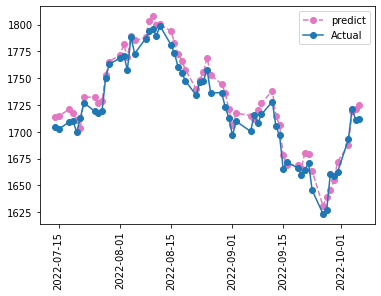

In [12]:
Close = Performance_tune(Gold,'Close',[i for i in range(1,30)],[i for i in range(2,60)],3)

In [13]:
#A dataframe created in the "performance" function which is consisting of Actual and predicted price
Close[2]

,Actual,Predict
0,1704.5,1713.324
1,1702.4,1714.632
2,1709.2,1720.986
3,1710.0,1717.772
4,1699.5,1711.183
5,1712.7,1703.146
6,1727.1,1732.169
7,1719.0,1732.443
8,1717.7,1726.512
9,1719.1,1728.283


# Another MLP Model (9 Layers)

At the end I develope another MLP model with 9 layers which is not tuned for a specific target column like "Close" as the above one.
It has lots of fault that can be resolve and improve.

In [14]:
def Performance(Data,col,Lag_list,Roll_window,mic):
    
    seed(111)

    data = Prepare(Data,col,Lag_list,Roll_window)
    df = Indicator(Data)
    data = pd.concat([df,data],axis=1)
    data = data.tail(data.shape[0]-100)
 
    MIC = mutual_information_lag(data,col,100)

    val = list(MIC[1].values())
    selected = [i for i in val if i > mic]
    bestCol = len(selected)
    Best_col = list(MIC[1].keys())
    Best_col = Best_col[:bestCol]
    Remove_col = list(set(data.columns[:-1]) - set(Best_col))
    data.drop(Remove_col,axis=1,inplace=True)
    #define train data
    x_scaler = PowerTransformer()
    X = data.values[:,:-1]
    X = x_scaler.fit_transform(X)

    X_train, X_test = X[:-60,:] , X[-60:,:]

    y_scaler = PowerTransformer()
    y = data.values[:,-1].reshape(-1, 1)
    y = y_scaler.fit_transform(y)

    y_train, y_test = y[:-60,:] , y[-60:,:]

    n_steps = X.shape[1]
    print(n_steps)

    # define model
    model = Sequential()
    #model.add(Dense(X.shape[1], activation='relu', input_dim=n_steps))
    model.add(Dense(8*n_steps, activation='relu', input_dim=n_steps, kernel_initializer='he_uniform'))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.001))
    #model.add(Dropout(0.1))
    #model.add(Dense(216, activation='sigmoid', kernel_initializer='he_uniform'))
    #model.add(Activation('relu'))
    #model.add(Dense(128, activation='sigmoid'))
    #model.add(Dense(32, activation='sigmoid'))
    #model.add(BatchNormalization())
    #model.add(Activation('relu'))
    #model.add(Dropout(0.01))
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    #model.add(BatchNormalization())
    #model.add(Activation('relu'))
    #model.add(Dropout(0.001))
    #model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    #model.add(BatchNormalization(momentum=1))
    #model.add(Activation('relu'))
    
    #model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    #model.add(BatchNormalization())
    #model.add(Activation('relu'))
    #model.add(Dropout(0.01))
    model.add(Dense(32, activation='sigmoid', kernel_initializer='he_uniform'))
    #model.add(BatchNormalization())
    #model.add(Activation('relu'))
    #model.add(Dropout(0.01))
    #model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
    #model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
    #model.add(BatchNormalization())
    model.add(Dense(16, activation='sigmoid', kernel_initializer='he_uniform'))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.01))
    model.add(Dense(16, activation='sigmoid', kernel_initializer='he_uniform'))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.02))
    model.add(Dense(16, activation='sigmoid', kernel_initializer='he_uniform'))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.02))
    model.add(Dense(16, activation='sigmoid', kernel_initializer='he_uniform'))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.02))
    model.add(Dense(8, activation='sigmoid', kernel_initializer='he_uniform'))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.01))
    #model.add(Dense(4, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1))
    #opt = SGD(lr=0.001, momentum=0.1)
    opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
    model.compile(optimizer=opt, loss='mean_squared_error',metrics=[tf.keras.metrics.RootMeanSquaredError()])
    #callbacks = [keras.callbacks.EarlyStopping(monitor='root_mean_squared_error',patience=10, restore_best_weights=True)]

    # fit model
    model.fit(X_train, y_train, epochs=300,batch_size=32, verbose=0)#,callbacks=callbacks)

    model.summary()
    # demonstrate prediction

    predict = model.predict(X_test, verbose=0)

    mae = mean_absolute_error(y_test, predict)
    rmse = sqrt(mean_squared_error(y_test, predict))
    print('MAE before inverse Scaling: %f' % mae)
    print('RMSE before inverse Scaling: %f' % rmse)

    y_test = y_scaler.inverse_transform(y_test)
    y_test = [ '%.1f' % y for y in y_test ]
    y_test = [float(i) for i in y_test]
    predict = y_scaler.inverse_transform(predict)
    predict = [ '%.3f' % y for y in predict ]
    predict = [float(i) for i in predict]

    
    x = data[-60:].index
    

    x = pd.DataFrame(Data.index[-60:]).values
    
    mae = mean_absolute_error(y_test, predict)
    rmse = sqrt(mean_squared_error(y_test, predict))
    
    
    compare = pd.DataFrame(columns=['Actual','Predict'])
    compare['Actual'] = y_test
    compare['Predict'] = predict
    print('=======')
    print('MAE after inverse Scaling: %f' % mae)
    print('RMSE after inverse Scaling: %f' % rmse)
    print('======Summary======')
    print('Lag_list:','===>','From:',min(Lag_list),'To:',max(Lag_list))
    print('Roll_window:','===>','From:',min(Roll_window),'To:',max(Roll_window))
    print('==============================')

    # plot prediction and actual price
    plt.plot(x, predict,'--bo', label = "predict",linestyle = 'dashed',color='C6')
    plt.plot(x, y_test,marker='o', label = "Actual")
    plt.xticks(rotation = 90)
    plt.legend()
    plt.show()
    return predict,y_test,compare

188
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1504)              284256    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                96320     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 16)           

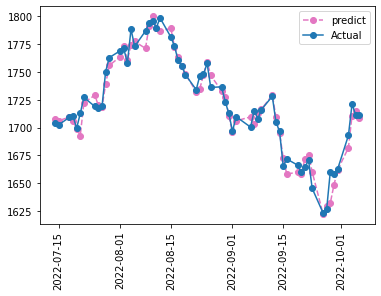

CPU times: user 3min 10s, sys: 10.8 s, total: 3min 21s
Wall time: 2min 46s


In [15]:
%%time
Close = Performance(Gold,'Close',[i for i in range(1,30)],[i for i in range(2,60)],3)

# Last Word
Thanks a lot for reading this notebook, I'll be grateful if you write your opinion about this notebook and help me to improve it friends.